## Predicting stock price
We will use the historical stock price of the New Germany Fund (GF) to try to predict the closing price in the next five trading days.
You can grab the dataset and notebook [here]('https://raw.githubusercontent.com/marcopeix/stock-prediction/master/data/stock_prices_sample.csv').

In [3]:
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

In [4]:
DATAPATH = 'data/stock_prices_sample.csv' #'https://raw.githubusercontent.com/marcopeix/stock-prediction/master/data/stock_prices_sample.csv'

df = pd.read_csv(DATAPATH, index_col='DATE', parse_dates=['DATE'])

df

,TICKER,FIGI,TYPE,FREQUENCY,OPEN,HIGH,LOW,CLOSE,VOLUME,ADJ_OPEN,ADJ_HIGH,ADJ_LOW,ADJ_CLOSE,ADJ_VOLUME,ADJ_FACTOR,EX_DIVIDEND,SPLIT_RATIO
DATE,,,,,,,,,,,,,,,,,
2013-01-04,GEF,BBG000BLFQH8,EOD,daily,46.31,47.6198,46.23,47.37,248000.0,38.517220,39.606614,38.450681,39.398849,248000.0,NaN,0.0,1.0
2013-01-03,GEF,BBG000BLFQH8,EOD,daily,46.43,46.5200,46.14,46.48,131300.0,38.617027,38.691882,38.375826,38.658613,131300.0,NaN,0.0,1.0
2013-01-02,GEF,BBG000BLFQH8,EOD,daily,45.38,46.5400,45.16,46.41,184900.0,37.743715,38.708516,37.560735,38.600392,184900.0,NaN,0.0,1.0
2018-06-05,GF,BBG000C3C6S2,Intraday,daily,18.86,18.9100,18.87,18.87,10000.0,18.860000,18.910000,18.870000,18.870000,10000.0,NaN,0.0,1.0
2018-06-04,GF,BBG000C3C6S2,EOD,daily,18.86,18.8900,18.79,18.81,39095.0,18.860000,18.890000,18.790000,18.810000,39095.0,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-06-27,GF,BBG000C3C6S2,EOD,daily,18.63,18.6300,18.51,18.61,28400.0,11.717560,11.717560,11.642085,11.704981,28400.0,NaN,0.0,1.0
2014-06-26,GF,BBG000C3C6S2,EOD,daily,18.52,18.5901,18.42,18.53,60000.0,11.648374,11.692464,11.585478,11.654664,60000.0,NaN,0.0,1.0
2014-06-25,GF,BBG000C3C6S2,EOD,daily,18.66,18.7200,18.59,18.60,171700.0,11.736429,11.774167,11.692402,11.698691,171700.0,NaN,0.0,1.0


## EDA

# Data Cleaning

Filter on the TICKER to retain only GF funds

In [10]:
df.TICKER.value_counts()

GF     996
GEF      3
Name: TICKER, dtype: int64

In [5]:
# df = df.query("TICKER == 'GF'")
df = df[df.TICKER == 'GF']

In [16]:
df.TICKER.value_counts()

GF    996
Name: TICKER, dtype: int64

In [22]:
# filter to the relevant Type
df.TYPE.value_counts()

EOD         995
Intraday      1
Name: TYPE, dtype: int64

In [6]:
df = df.query("TYPE == 'EOD'")

In [28]:
df.TYPE.value_counts()

EOD    995
Name: TYPE, dtype: int64

Remove unneeded columns

In [7]:
# df.columns
sel_cols = ['TICKER','OPEN', 'HIGH', 'LOW', 'CLOSE', ]

df = df[sel_cols]

df

,TICKER,OPEN,HIGH,LOW,CLOSE
DATE,,,,,
2018-06-04,GF,18.86,18.8900,18.7900,18.8100
2018-06-01,GF,18.58,18.7600,18.5800,18.7400
2018-05-31,GF,18.52,18.5200,18.3012,18.4900
2018-05-30,GF,18.47,18.6780,18.4700,18.6500
2018-05-29,GF,18.51,18.5100,18.1500,18.2562
...,...,...,...,...,...
2014-06-27,GF,18.63,18.6300,18.5100,18.6100
2014-06-26,GF,18.52,18.5901,18.4200,18.5300
2014-06-25,GF,18.66,18.7200,18.5900,18.6000


## Visualization

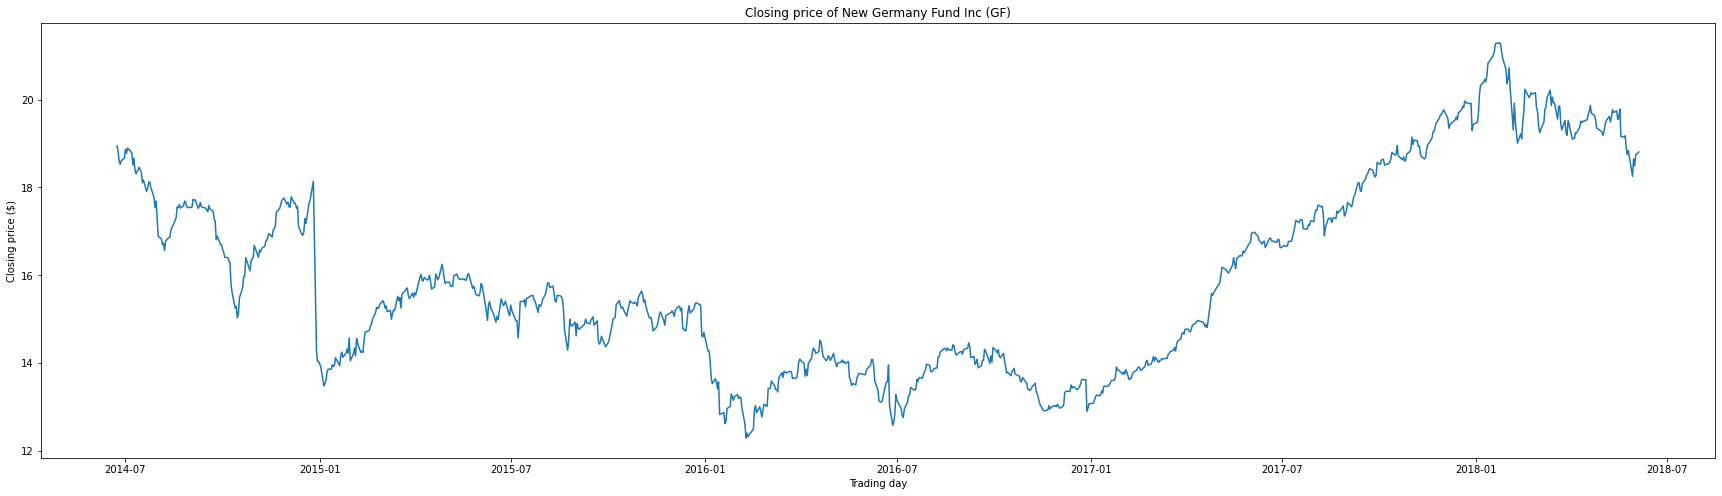

In [32]:
# Plot closing price

plt.figure(figsize=(30, 8))

plt.plot(df.CLOSE)

plt.title('Closing price of New Germany Fund Inc (GF)')
plt.ylabel('Closing price ($)')
plt.xlabel('Trading day')
plt.grid(False)

plt.show()

In [36]:
a = 30

np.abs(a)

30

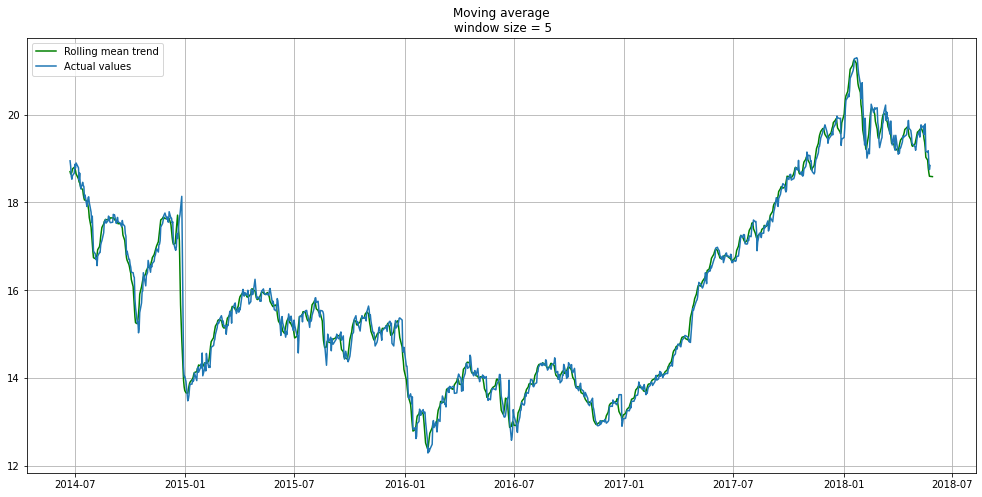

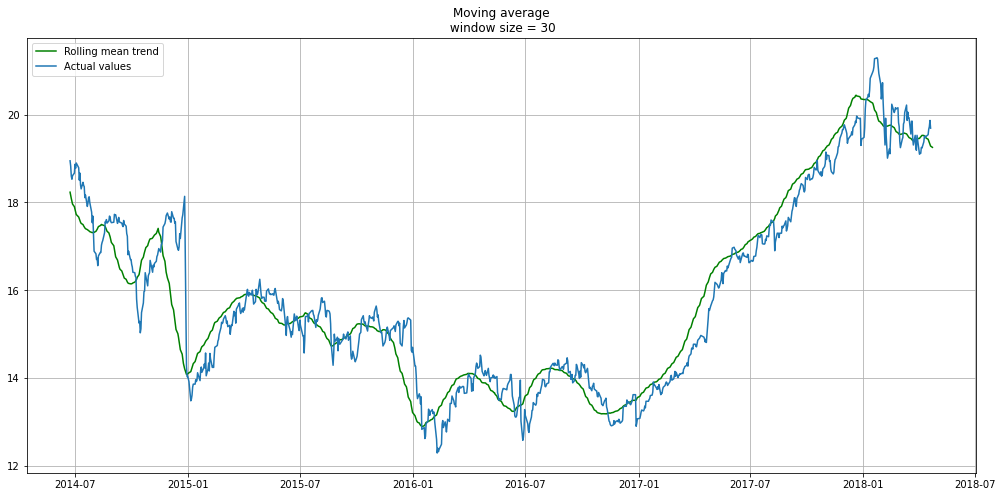

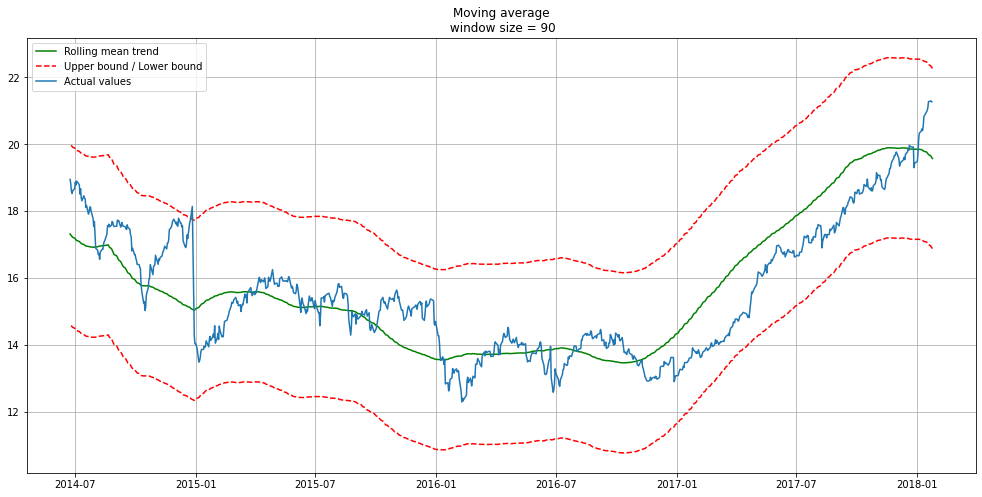

In [39]:
data = df


def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    plt.plot(series[window:], label='Actual values')
    plt.legend(loc='best')
    plt.grid(True)
    
#Smooth by the previous 5 days (by week)
plot_moving_average(data.CLOSE, 5)

#Smooth by the previous month (30 days)
plot_moving_average(data.CLOSE, 30)

#Smooth by previous quarter (90 days)
plot_moving_average(data.CLOSE, 90, plot_intervals=True)

## Exponential Smoothing

![Exponential Smoothing Expression](https://miro.medium.com/max/1050/1*d8UsN4g3URJAaaEzD-zyZA.png)

α is athe smoothing factor 0 <= α <= 1

![Double Exponential Smoothing](https://miro.medium.com/max/1050/1*Ng9wsOnjHu8FAse6ba2mwg.png)

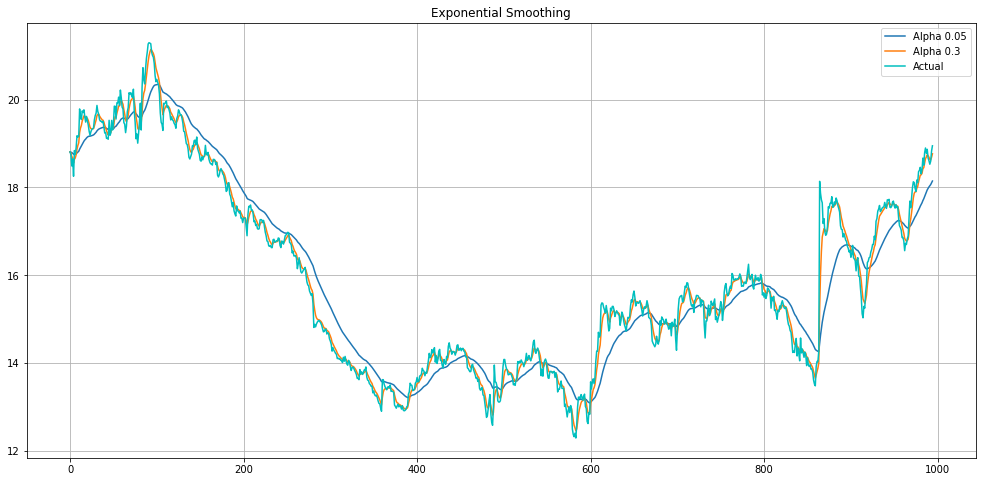

In [10]:
data = df

def exponential_smoothing(series, alpha):

    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result
  
def plot_exponential_smoothing(series, alphas):
 
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, alpha), label="Alpha {}".format(alpha))
    plt.plot(series.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

plot_exponential_smoothing(data.CLOSE, [0.05, 0.3])


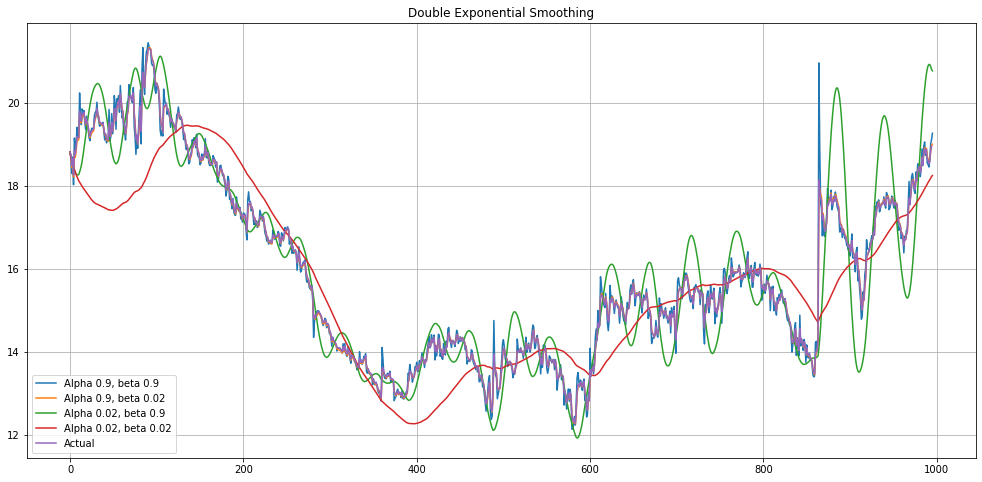

In [11]:
# Double Exponential Smoothing

def double_exponential_smoothing(series, alpha, beta):

    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # forecasting
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha * value + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

def plot_double_exponential_smoothing(series, alphas, betas):
     
    plt.figure(figsize=(17, 8))
    for alpha in alphas:
        for beta in betas:
            plt.plot(double_exponential_smoothing(series, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(series.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)
    
plot_double_exponential_smoothing(data.CLOSE, alphas=[0.9, 0.02], betas=[0.9, 0.02])


### Modeling Time Series Process

In statistics, the Dickey–Fuller test tests the null hypothesis that a unit root is present in an autoregressive time series model. The alternative hypothesis is different depending on which version of the test is used, but is usually stationarity or trend-stationarity. The test is named after the statisticians David Dickey and Wayne Fuller, who developed it in 1979.

In [18]:
isinstance(df.CLOSE,pd.Series)

True

C:\Users\ng005454\OneDrive\Project\STUTERN\SGA11_DSCI\02112021\env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\ng005454\OneDrive\Project\STUTERN\SGA11_DSCI\02112021\env\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


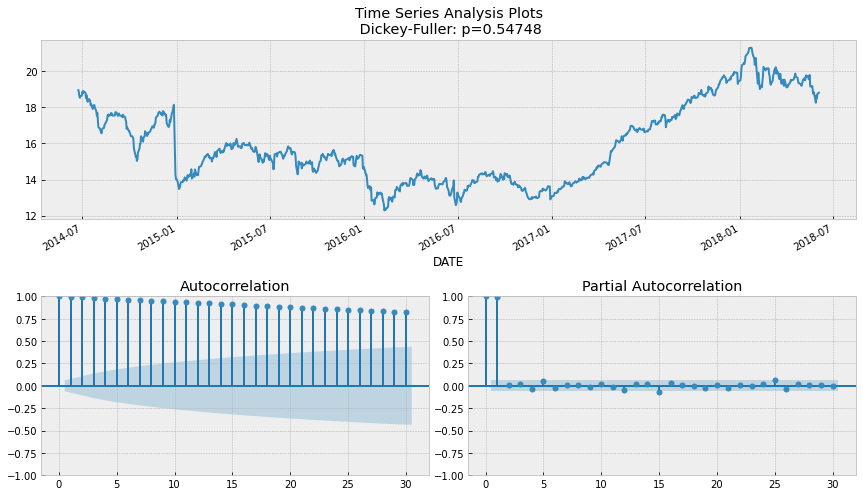

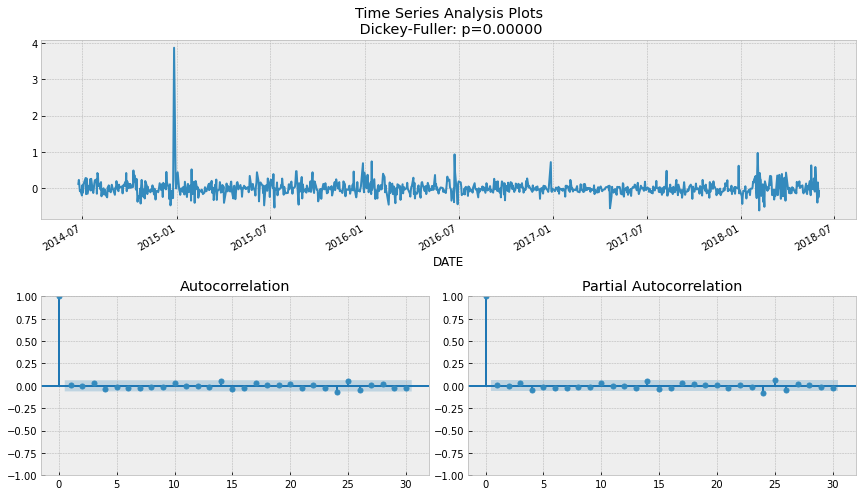

In [19]:
def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
        
tsplot(data.CLOSE, lags=30)

# Take the first difference to remove to make the process stationary
data_diff = data.CLOSE - data.CLOSE.shift(1)

tsplot(data_diff[1:], lags=30)


In [21]:
# help(smt.graphics.plot_acf)
data_diff

DATE
2018-06-04       NaN
2018-06-01   -0.0700
2018-05-31   -0.2500
2018-05-30    0.1600
2018-05-29   -0.3938
               ...  
2014-06-27   -0.0601
2014-06-26   -0.0800
2014-06-25    0.0700
2014-06-24    0.2300
2014-06-23    0.1200
Name: CLOSE, Length: 995, dtype: float64